In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize_scalar
from sklearn.tree import DecisionTreeRegressor
import time
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from google.colab import files

%matplotlib inline
%config InlineBackend.figure_formats = 'svg'

In [ ]:
!cp 'drive/MyDrive/prak/ensembles/ensembles.py' 'ensembles.py'
!cp 'drive/MyDrive/prak/ensembles/kc_house_data.csv' 'kc_house_data.csv'
from ensembles import RandomForestMSE, GradientBoostingMSE

In [ ]:
df = pd.read_csv('kc_house_data.csv')
df

id             date  ...  sqft_living15  sqft_lot15
0      7129300520  20141013T000000  ...           1340        5650
1      6414100192  20141209T000000  ...           1690        7639
2      5631500400  20150225T000000  ...           2720        8062
3      2487200875  20141209T000000  ...           1360        5000
4      1954400510  20150218T000000  ...           1800        7503
...           ...              ...  ...            ...         ...
21608   263000018  20140521T000000  ...           1530        1509
21609  6600060120  20150223T000000  ...           1830        7200
21610  1523300141  20140623T000000  ...           1020        2007
21611   291310100  20150116T000000  ...           1410        1287
21612  1523300157  20141015T000000  ...           1020        1357

[21613 rows x 21 columns]

In [ ]:
forest = RandomForestMSE(1000, 10)

In [ ]:
hist = forest.fit(np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), trace=True)[1]

In [ ]:
hist['test_rmses'][-1]

158331.184469107

In [ ]:
boosting = GradientBoostingMSE(300)

In [ ]:
hist = boosting.fit(np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), trace=True)[1]

In [ ]:
hist['test_rmses'][-1]

230571.56672765815

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].apply(lambda x: x.timetuple().tm_yday)
df['month'] = df['date'].dt.month

In [ ]:
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.xlabel('Номер дня в году')
plt.ylabel('Цена')
plt.scatter(df['day'], df['price'])

In [ ]:
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.xlabel('Номер месяца')
plt.ylabel('Цена')
plt.scatter(df['month'], df['price'])

In [ ]:
df1 = df.copy()
y = np.array(df1['price'])
df1.drop(['id', 'price', 'date'], axis=1, inplace=True)

In [ ]:
df1.columns, len(df1.columns)

(Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
        'waterfront', 'view', 'condition', 'grade', 'sqft_above',
        'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
        'sqft_living15', 'sqft_lot15', 'day', 'month'],
       dtype='object'), 20)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df1, y, test_size=0.3, random_state=10)

In [ ]:
X_train, X_test = np.array(X_train), np.array(X_test)

Эксперимент 2

In [ ]:
n_trees = 500
n_features = [1, 3, 5, 6, 7, 10, 12, 14, 16, 18, 20]
depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None]

In [ ]:
np.random.seed(77)
forest_trees = RandomForestMSE(n_estimators=n_trees, max_depth=5)
hist_trees = forest_trees.fit(X_train, y_train, X_val=X_test, y_val=y_test, trace=True)[1]

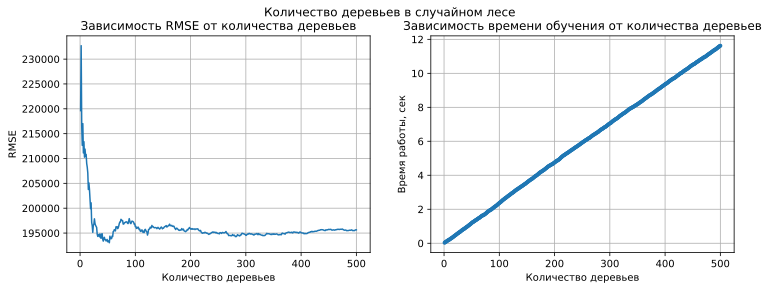

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(np.arange(1, n_trees + 1), hist_trees['test_rmses'])
ax[1].plot(np.arange(1, n_trees + 1), hist_trees['times'])

ax[0].grid()
ax[1].grid()
ax[0].set_xlabel('Количество деревьев')
ax[0].set_ylabel('RMSE')
ax[1].set_xlabel('Количество деревьев')
ax[1].set_ylabel('Время работы, сек')
ax[0].set_title('Зависимость RMSE от количества деревьев')
ax[1].set_title('Зависимость времени обучения от количества деревьев')

plt.suptitle("Количество деревьев в случайном лесе")
fig.show()
fig.savefig('random_forest_trees.svg')
files.download('random_forest_trees.svg')

In [ ]:
np.array(hist_trees['test_rmses']).argmin()

52

In [ ]:
np.random.seed(77)
forests_features = []
times_features = []
rmses_features = []
for n_f in tqdm(n_features):
  forest = RandomForestMSE(n_estimators=50, max_depth=5, feature_subsample_size=n_f)
  forests_features.append(forest)
  hist = forest.fit(X_train, y_train, X_val=X_test, y_val=y_test, trace=True)[1]
  times_features.append(hist['times'][-1])
  rmses_features.append(hist['test_rmses'][-1])

  0%|          | 0/11 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

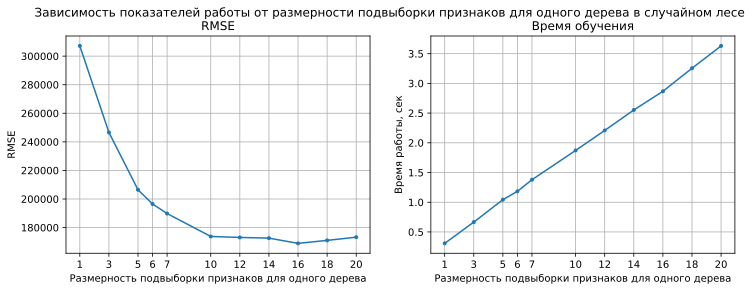

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(n_features, rmses_features, marker='.')
ax[1].plot(n_features, times_features, marker='.')

ax[0].grid()
ax[1].grid()
ax[0].set_xlabel('Размерность подвыборки признаков для одного дерева')
ax[0].set_ylabel('RMSE')
ax[1].set_xlabel('Размерность подвыборки признаков для одного дерева')
ax[1].set_ylabel('Время работы, сек')
ax[0].set_title('RMSE')
ax[1].set_title('Время обучения')
ax[0].set_xticks(n_features)
ax[1].set_xticks(n_features)

plt.suptitle("Зависимость показателей работы от размерности подвыборки признаков для одного дерева в случайном лесе")
fig.show()
fig.savefig('random_forest_features.svg')
files.download('random_forest_features.svg')

In [ ]:
np.random.seed(77)
forests_depth = []
times_depth = []
rmses_depth = []
for depth in tqdm(depths):
  forest = RandomForestMSE(n_estimators=50, max_depth=depth)
  forests_depth.append(forest)
  hist = forest.fit(X_train, y_train, X_val=X_test, y_val=y_test, trace=True)[1]
  times_depth.append(hist['times'][-1])
  rmses_depth.append(hist['test_rmses'][-1])

  0%|          | 0/11 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

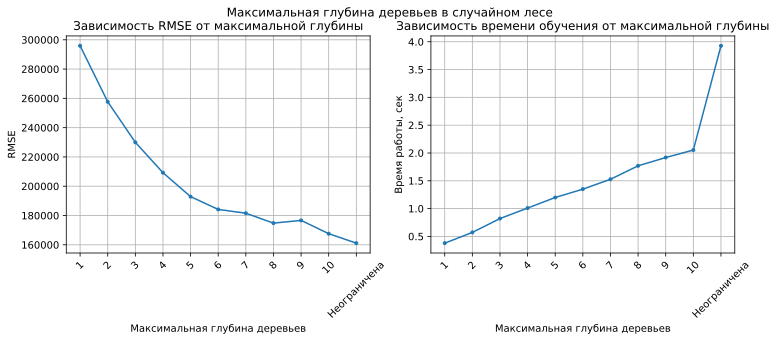

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot([str(d) for d in depths[:-1]] + ['Неограничена'], rmses_depth, marker='.')
ax[1].plot([str(d) for d in depths[:-1]] + ['Неограничена'], times_depth, marker='.')

ax[0].grid()
ax[1].grid()
ax[0].set_xlabel('Максимальная глубина деревьев')
ax[0].set_ylabel('RMSE')
ax[1].set_xlabel('Максимальная глубина деревьев')
ax[1].set_ylabel('Время работы, сек')
ax[0].set_title('Зависимость RMSE от максимальной глубины')
ax[1].set_title('Зависимость времени обучения от максимальной глубины')
ax[0].tick_params(axis='x', labelrotation = 45)
ax[1].tick_params(axis='x', labelrotation = 45)

plt.suptitle("Максимальная глубина деревьев в случайном лесе")
fig.show()
fig.savefig('random_forest_depth.svg')
files.download('random_forest_depth.svg')

In [ ]:
rmses_depth

[295885.69525012805,
 257665.23584092024,
 229974.51362355246,
 209233.5405337226,
 192875.61500676107,
 184149.00147872747,
 181565.03416337824,
 174800.328936549,
 176661.5755236084,
 167585.55289698156,
 161125.06100348834]

Эксперимент 3

In [ ]:
n_trees = 500
np.random.seed(77)
boosting_trees = GradientBoostingMSE(n_estimators=n_trees, learning_rate=0.5)
bhist_trees = boosting_trees.fit(X_train, y_train, X_val=X_test, y_val=y_test, trace=True)[1]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

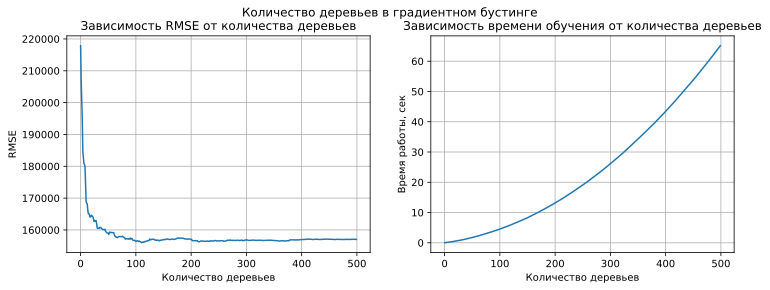

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(np.arange(n_trees), bhist_trees['test_rmses'])
ax[1].plot(np.arange(n_trees), bhist_trees['times'])

ax[0].grid()
ax[1].grid()
ax[0].set_xlabel('Количество деревьев')
ax[0].set_ylabel('RMSE')
ax[1].set_xlabel('Количество деревьев')
ax[1].set_ylabel('Время работы, сек')
ax[0].set_title('Зависимость RMSE от количества деревьев')
ax[1].set_title('Зависимость времени обучения от количества деревьев')

plt.suptitle("Количество деревьев в градиентном бустинге")
fig.show()
fig.savefig('boosting_trees.svg')
files.download('boosting_trees.svg')

In [ ]:
np.random.seed(77)
bforests_features = []
btimes_features = []
brmses_features = []
for n_f in tqdm(n_features):
  boosting = GradientBoostingMSE(n_estimators=100, feature_subsample_size=n_f)
  bforests_features.append(boosting)
  hist = boosting.fit(X_train, y_train, X_val=X_test, y_val=y_test, trace=True)[1]
  btimes_features.append(hist['times'][-1])
  brmses_features.append(hist['test_rmses'][-1])

  0%|          | 0/11 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

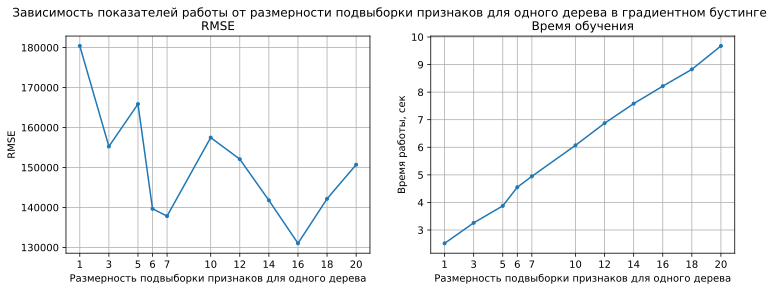

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(n_features, brmses_features, marker='.')
ax[1].plot(n_features, btimes_features, marker='.')

ax[0].grid()
ax[1].grid()
ax[0].set_xlabel('Размерность подвыборки признаков для одного дерева')
ax[0].set_ylabel('RMSE')
ax[1].set_xlabel('Размерность подвыборки признаков для одного дерева')
ax[1].set_ylabel('Время работы, сек')
ax[0].set_title('RMSE')
ax[1].set_title('Время обучения')
ax[0].set_xticks(n_features)
ax[1].set_xticks(n_features)

plt.suptitle("Зависимость показателей работы от размерности подвыборки признаков для одного дерева в градиентном бустинге")
fig.show()
fig.savefig('boosting_features.svg')
files.download('boosting_features.svg')

In [ ]:
np.random.seed(77)
bforests_depth = []
btimes_depth = []
brmses_depth = []
for depth in tqdm(depths):
  boosting = GradientBoostingMSE(n_estimators=100, max_depth=depth)
  bforests_depth.append(boosting)
  hist = boosting.fit(X_train, y_train, X_val=X_test, y_val=y_test, trace=True)[1]
  btimes_depth.append(hist['times'][-1])
  brmses_depth.append(hist['test_rmses'][-1])

  0%|          | 0/11 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

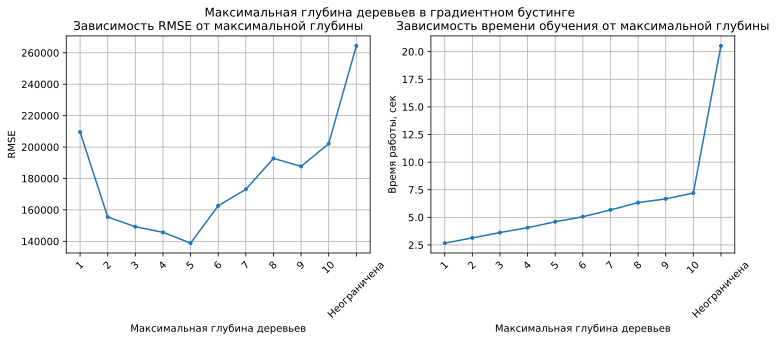

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot([str(d) for d in depths[:-1]] + ['Неограничена'], brmses_depth, marker='.')
ax[1].plot([str(d) for d in depths[:-1]] + ['Неограничена'], btimes_depth, marker='.')

ax[0].grid()
ax[1].grid()
ax[0].set_xlabel('Максимальная глубина деревьев')
ax[0].set_ylabel('RMSE')
ax[1].set_xlabel('Максимальная глубина деревьев')
ax[1].set_ylabel('Время работы, сек')
ax[0].set_title('Зависимость RMSE от максимальной глубины')
ax[1].set_title('Зависимость времени обучения от максимальной глубины')
ax[0].tick_params(axis='x', labelrotation = 45)
ax[1].tick_params(axis='x', labelrotation = 45)

plt.suptitle("Максимальная глубина деревьев в градиентном бустинге")
fig.show()
fig.savefig('boosting_depth.svg')
files.download('boosting_depth.svg')

In [ ]:
lrs = [0.001, 0.01, 0.05, 0.1, 0.5, 1]
np.random.seed(77)
bforests_lr = []
btimes_lr = []
brmses_lr = []
for lr in tqdm(lrs):
  boosting = GradientBoostingMSE(n_estimators=500, learning_rate=lr)
  bforests_lr.append(boosting)
  hist = boosting.fit(X_train, y_train, X_val=X_test, y_val=y_test, trace=True)[1]
  btimes_lr.append(hist['times'][-1])
  brmses_lr.append(hist['test_rmses'][-1])

  0%|          | 0/6 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

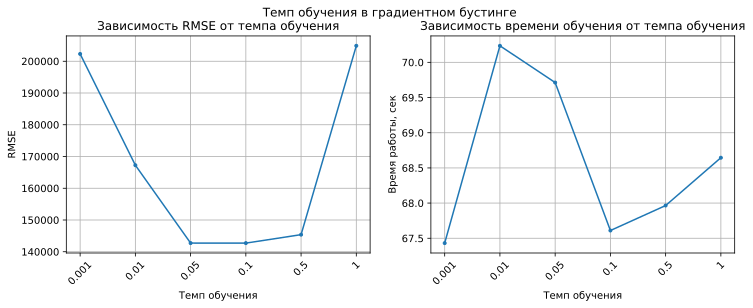

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot([str(lr) for lr in lrs], brmses_lr, marker='.')
ax[1].plot([str(lr) for lr in lrs], btimes_lr, marker='.')

ax[0].grid()
ax[1].grid()
ax[0].set_xlabel('Темп обучения')
ax[0].set_ylabel('RMSE')
ax[1].set_xlabel('Темп обучения')
ax[1].set_ylabel('Время работы, сек')
ax[0].set_title('Зависимость RMSE от темпа обучения')
ax[1].set_title('Зависимость времени обучения от темпа обучения')
ax[0].tick_params(axis='x', labelrotation = 45)
ax[1].tick_params(axis='x', labelrotation = 45)

plt.suptitle("Темп обучения в градиентном бустинге")
fig.show()
fig.savefig('boosting_lr.svg')
files.download('boosting_lr.svg')

In [ ]:
lrs = [0.001, 0.01, 0.05, 0.1, 0.5, 1, 2]
np.random.seed(77)
bforests_lr = []
btimes_lr = []
brmses_lr = []
for lr in tqdm(lrs):
  boosting = GradientBoostingMSE(n_estimators=100, learning_rate=lr)
  bforests_lr.append(boosting)
  hist = boosting.fit(X_train, y_train, X_val=X_test, y_val=y_test, trace=True)[1]
  btimes_lr.append(hist['times'][-1])
  brmses_lr.append(hist['test_rmses'][-1])

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot([str(lr) for lr in lrs], brmses_lr, marker='.')
ax[1].plot([str(lr) for lr in lrs], btimes_lr, marker='.')

ax[0].grid()
ax[1].grid()
ax[0].set_xlabel('Темп обучения')
ax[0].set_ylabel('RMSE')
ax[1].set_xlabel('Темп обучения')
ax[1].set_ylabel('Время работы, сек')
ax[0].set_title('Зависимость RMSE от темпа обучения')
ax[1].set_title('Зависимость времени обучения от темпа обучения')
ax[0].tick_params(axis='x', labelrotation = 45)
ax[1].tick_params(axis='x', labelrotation = 45)

plt.suptitle("Темп обучения в градиентном бустинге")
fig.show()
fig.savefig('boosting_lr.svg')
files.download('boosting_lr.svg')